# The g-h Filter

> In essence, two sensors, even if one is less accurate than the other, is better than one sensor.

Sensors are inaccurate. The question is how to improve upon the result of a sensor? The mathematical term for these situations when two sensors give disparate results is called *expected value*. Even when two sensors are compared, and one sensor is a factor more accurate than the other, the less accurate of the two can still provide information and improve our knowledge over A. Let us take a thought experiment:

1. Sensor A is accurate to 1kg and measures 160kg.
    1. Possible values are: [159, 160, 161]
2. Sensor B is accurate to 9kg and measures 170kg.
    1. Possible values are: [161, 170, 179]
3. With both sensors only potential value is: 161kg. 

This is the value that both the sensors can reliably measure and therefore makes the most amount of sense. However, we can not sell multiple sensors. Assume we sell sensor A. The thought experiment and the conclusion to have is this: the average of a large number of weighings will be closer to my actual weight.

1. Assuming the weight is 170kg.
    1. Average of a bunch of 170s is 170 and can be excluded. 
2. Since the Sensor is accurate to 1kg, the other values are 169 and 171 respectively.
    1. There averages assuming there will be a large amount of those values will amount to 170.
    2. This gives us that the actual value is actually 170 rather than any other value.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

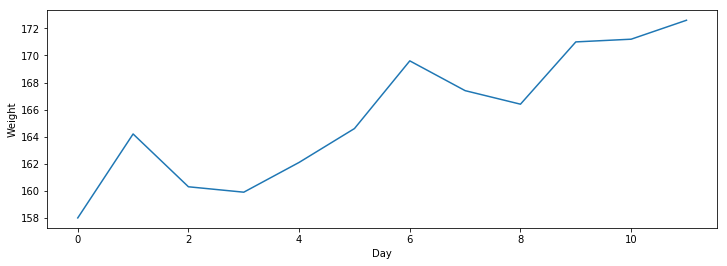

In [6]:
weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6,
           169.6, 167.4, 166.4, 171.0, 171.2, 172.6]
# --
plt.figure(figsize=(12, 4))
plt.plot(weights)
plt.xlabel("Day")
plt.ylabel("Weight")
plt.show()

The above data looks noisy. And the data doesn't look like the weight held steady over the period of measurements. There are two assumptions to make:

1. The weight did not change and therefore compute the mean for the data.
2. The weight was gained over the course of the period.

The second assumption can be drawn using a *least squares fit*. However, the data seems to show a gain of 13kg in weight. For thought, let's assume that the weight gain is indeed 1kg per day. The value starts at 158kg. A 1kg a day gain indicates that the weight at day-2 is actually 159, however the measured value is 164.2kg. The predicted value does not seem to match the actual measurement. The requirement is to blend both the measurement and the prediction.

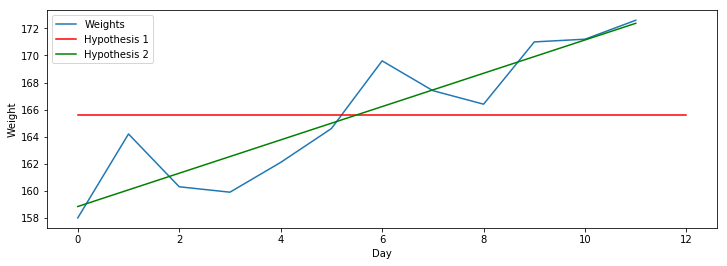

In [46]:
plt.figure(figsize=(12, 4))
plt.plot(weights, label="Weights")
ave = np.sum(weights) / len(weights)
plt.plot([0, 12], [weights.mean(), weights.mean()], c="r",
         label="Hypothesis 1")
# -- least squares fit --
xs = range(len(weights))
line = np.poly1d(np.polyfit(xs, weights, 1))
plt.plot(xs, line(xs), c="g", label="Hypothesis 2")
# --
plt.xlabel("Day")
plt.ylabel("Weight")
plt.legend()
plt.show()

The first step is to predict with a random number. The assumption to work with is that the prediction we perform will always be 4/10th of the actual measurement and the rest will be from the actual measurement. The belief is that the prediction is more accurate than the measurement. 

```
estimate = prediction + 4/10 (measurement - prediction)
```

The difference between the measurement and the prediction can be called the *residual*. Smaller residuals imply better performance. This guessing method can be called the `gain guess` estimator. 

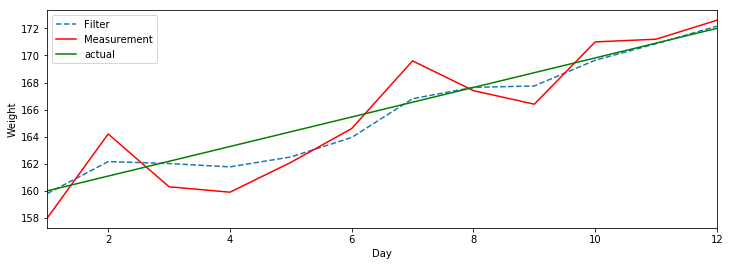

In [75]:
def predict_using_gain_guess(measure, initial, gain, ts, sf):
    """
    measurement: measured values
    initial: initial guess value
    gain: gain value
    ts : time step
    sf : scale factor
    """
    estimates = []
    n = len(weights)
    # Take measurements as z
    for z in weights:
        prediction = initial + gain * ts
        initial = prediction + sf * (z - prediction)
        estimates.append(initial)
        # --
    plt.figure(figsize=(12, 4))
    plt.xlim([1, n])
    plt.plot(range(1, n+1), estimates, "--", label="Filter")
    plt.plot(range(1, n+1), weights, "r", label="Measurement")
    plt.plot([1, n], [160, 160+n],
             c="g", label="actual")
    plt.legend(loc="best")
    plt.xlabel("Day")
    plt.ylabel("Weight")
    plt.show()
# --
predict_using_gain_guess(weights, initial=160, gain=1, ts=1, sf=4/10)

The problem with the above filter is that the rate of change needs a guess. The filter will fail when the rate of change changes. The next optimization would be use the previous known gain and alter with the now known gain. This would improve our prediction by quite a lot. The equation to incorporate a new gain is:

```
new gain = old gain + 1 / 3 (measurement - predicted weight) / 1 day
```

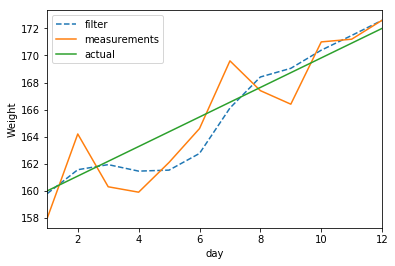

In [78]:
def predict_using_gain_correction(measure, initial, gain, ts, gain_scale, weight_scale):
    estimates = []
    for z in weights:
        initial = initial + gain * ts
        gain = gain
        residual = z - initial
        gain = gain + gain_scale * (residual / ts)
        initial = initial + weight_scale * residual
        estimates.append(initial)
    # --
    n = len(measure)
    plt.xlim([1, n])
    plt.plot(range(1, n+1), estimates, "--", label="filter")
    plt.plot(range(1, n+1), measure, label="measurements")
    plt.plot([1, n], [160, 160+n], label="actual")
    plt.legend(loc="best")
    plt.xlabel("day")
    plt.ylabel("Weight")
    plt.show()
# --
predict_using_gain_correction(weights, 160, 1, 1, gain_scale=1/3,
                              weight_scale=4/10)

The algorithm is called the g-h filter where `g` and `h` are the two scaling factors. `G` is the scaling used for the measurement and `h` is the scaling used for the change in measurement over time. The Kalman filter is a form of g-h filter with different filters having different methods by which g and h are assigned. The $\alpha - \beta$ filter assigns constants constrained to specific range of values and is a form of g-h filter. There are atleast 11 filters which are a type of g-h filter The key takeaways:

- Multiple measurements are more accurate than one measurement
- Always choose a number part way between two measurements to create an accurate estimate
- Predict next based on the current estimate and how much it is supposed to change
- New estimate is chosen as part way between the prediction and the next measurement

## Nomenclature

Measurements are denoted by $z$ and the subscript $k$ indicates the timestep. $x$ is a vector and $\hat{x}$ indicates an *estimate* so the estimate at time k is given by $\bar{x}_k$. The initial state is given by $x_0$ and the measurement at a time is $z_k$ forming the estimate at $\bar{x}_k$ at that time point.

In [81]:
def g_h_filter(data, x0, dx, g, h, dt=1.0, pred=None):
    """Comments"""
    x = x0
    results = []
    for z in data:
        x_est = x + (dx * dt)
        dx = dx
        if pred is not None:
            pred.append(x_est)
        
        # update step
        residual = z - x_est
        dx = dx + h * (residual / dt)
        x = x_est + g * residual
        results.append(x)
    
    return results
# --
def plot_g_h_filter(measure, filtered, title=''):
    plt.figure(figsize=(12, 4))
    plt.plot(measure, label="measurement")
    plt.plot(filtered, "--", label="filter")
    plt.legend(loc="best")
    plt.title(title)
    plt.show()

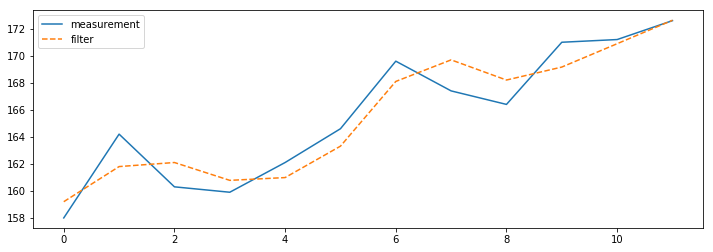

In [83]:
data = g_h_filter (data=weights, x0=160, dx=1, g=6./10, h = 2./3, dt=1.)
plot_g_h_filter(weights, data)

## Exercise: Create Measurement Function

**Problem** : A function that is called with a starting value , the amount of change per step, the number of steps and the amount of noise to add. This should return a list of data. 

To do:

1. Create 30 points
2. Filter it with g_h_filter
3. Plot it with the plotting function

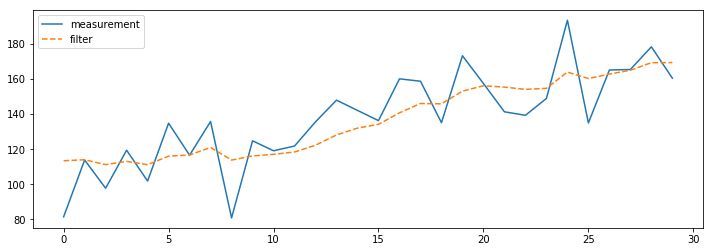

In [95]:
np.random.seed(400)
# -
def generate_data(x0, dx, n, noise_factor):
    return [x0 + dx * i + np.random.randn() * noise_factor for i in range(n)]
# --
_measure = generate_data(100, 2.42, 30, 16.4)
_estimate = g_h_filter(_measure, 120, 1.4, 0.2, 0.02, 1)
plot_g_h_filter(_measure, _estimate)

## Exercise: Bad Initial Conditions

**Problem**: Start at a bad initial guess of 180 with scaling factors g=0.2, h=0.02 against a measured value beginning at 5 with a derivative of 2 and a noise factor of 10.

**Result**:

The data shows an overshooting before it start settling in a sinusoidal type pattern. This method is called 'Ringing'. This is a common filter phenomena and a lot of work tries to attenuate this ringing. 

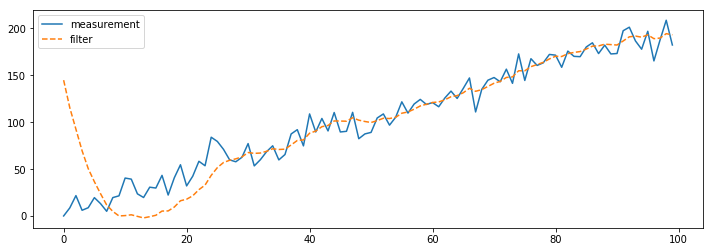

In [97]:
_measure = generate_data(x0=5, dx=2, n=100, noise_factor=10)
_estimate = g_h_filter(_measure, 180, 1, 0.2, 0.02, 1)
plot_g_h_filter(_measure, _estimate)

## Exercise: Extreme Noise

**Problem**: Use a very high noise factor and remove the ringing.

**Result**

- The data in some locations shows signs of overshooting and undershooting as it struggles to be a straight line. 

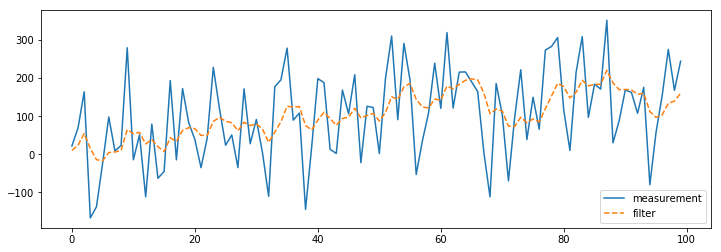

In [98]:
_measure = generate_data(x0=5, dx=2, n=100, noise_factor=100)
_estimate = g_h_filter(data=_measure, x0=5, dx=2, g=0.2, h=0.02, dt=1.0)
plot_g_h_filter(_measure, _estimate)

## Exercise: Effect of Acceleration

**Problem**: Generate a new data that adds a constant acceleration factor to each data point. Increment `dx` as you compute each data point so that the velocity is increasing while setting the noise to 0, g=0.2, h=0.02.

**Results**

- g-h filter plots the first derivative and not the second derivative.
- This results in the filter lagging behind the measured value since the h can only partially adjust to the new value. 
- This is called *lag error* or *systemic error* of the system.

> The filter is only as the mathematical system used to express the system


In [101]:
def gen_accelerated(x0, dx, count, noise, accel):
    res = []
    for i in range(count):
        res.append(x0 + dx * i + np.random.randn() * noise)
        dx += accel
    return res

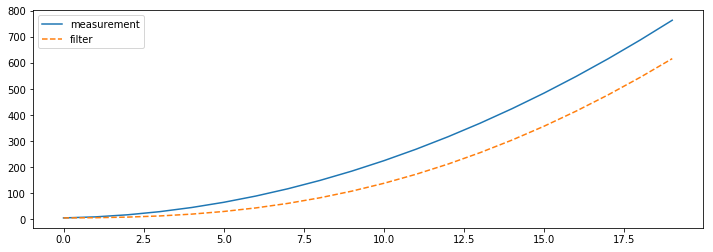

In [104]:
_measure = gen_accelerated(5, 2, 20, 0, accel=2)
_estimate = g_h_filter(data=_measure, x0=5, dx=0, g=0.2, h=0.02, dt=1.0)
plot_g_h_filter(_measure, _estimate)

## Exercise: Varying G

**Problem**: G is the scaling factor for choosing between the measurement and the prediction. Identify the impact of the value of g being large.

**Result**:

- As g goes towards 1, the overall value becomes closer and closer to the actual measurement as the value chosen becomes the actual measurement rather than the prediction.

- Example, Benedict-Bordner filter was invented to minimize the transient error when the change is a step function. There are filter designs that are helpful in making sure such transient jumps are mitigated.

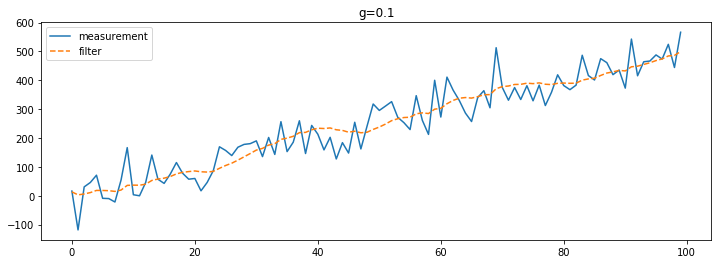

In [107]:
_measure = generate_data(5, dx=5, n=100, noise_factor=50)
# -- g = 0.1
_estimate = g_h_filter(_measure, x0=10, dx=3, g=0.1, h=0.02)
plot_g_h_filter(_measure, _estimate, title="g=0.1")

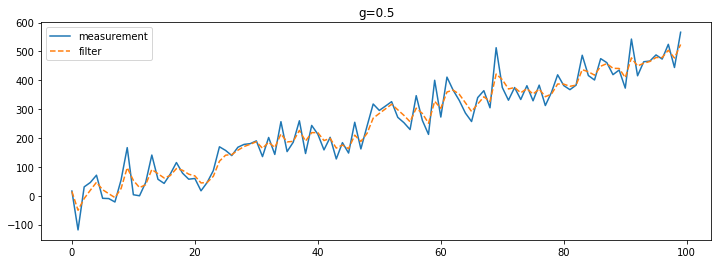

In [108]:
_estimate = g_h_filter(_measure, x0=10, dx=3, g=0.5, h=0.02)
plot_g_h_filter(_measure, _estimate, title="g=0.5")

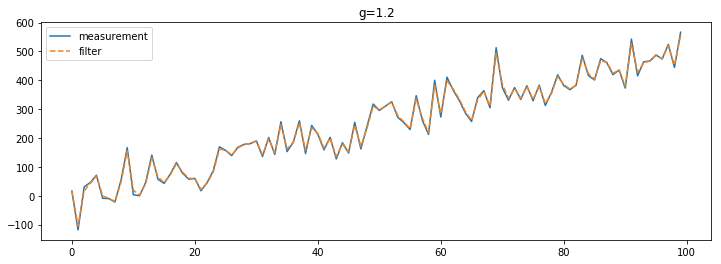

In [114]:
_estimate = g_h_filter(_measure, x0=10, dx=3, g=0.9, h=0.02)
plot_g_h_filter(_measure, _estimate, title="g=1.2")

## Exercise: Varying h

**Problem**: $h$ is how much we favor the measurement of $\dot{x}$ vs our prediction. If signal is changing a lot, then a large $h$ helps the filter to react to those changes quickly while a smaller $h$ reacts more slowly. 

**Results**:

- Generates a ringing as the filter finds the signal. 

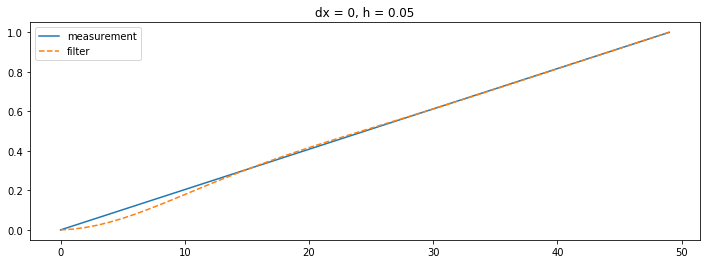

In [118]:
_measure = np.linspace(0, 1, 50)
# --
_estimate = g_h_filter(_measure, x0=0, dx=0., dt=1., g=0.2, h=0.05)
plot_g_h_filter(_measure, _estimate, title="dx = 0, h = 0.05")

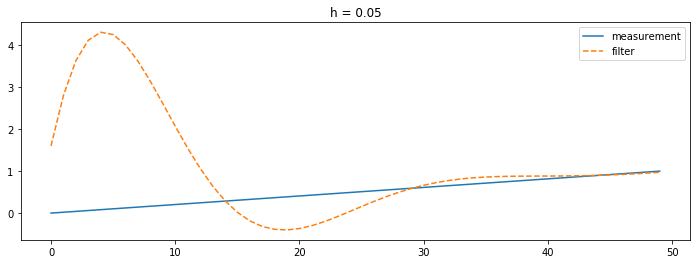

In [116]:
_estimate = g_h_filter(_measure, x0=0, dx=2., dt=1., g=0.2, h=0.05)
plot_g_h_filter(_measure, _estimate, title="dx = 2, h = 0.05")

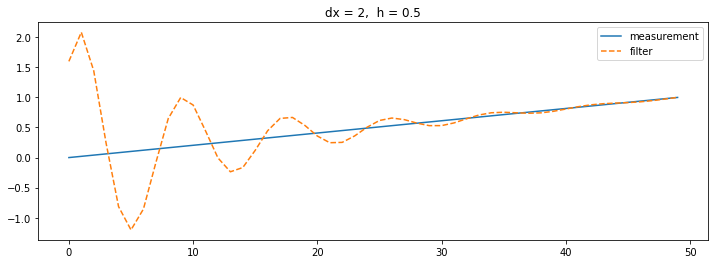

In [123]:
_estimate = g_h_filter(_measure, x0=0, dx=2., dt=1., g=0.2, h=0.5)
plot_g_h_filter(_measure, _estimate, title="dx = 2,  h = 0.5")

## Summary

- Filters are designed and not *ad hoc*
- Designing Kalman filter requires specifying parameters but not directly the *g* and *h* values.